In [1]:
!pip3 install dataset

  Using cached https://files.pythonhosted.org/packages/9f/4d/f74a514b5c4efb5c1546160597715cd6096273d7173b36a3187d2afb663a/dataset-1.6.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ae/c4/7f6e6a539cc6b2da4da3b6a58d5e6f9342c870522ee46d41f8cbd2156953/banal-1.0.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b3/e2/8d48220731b7279911c43e95cd182961a703b939de6822b00de3ea0d3159/alembic-1.7.7-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/84/17/3231f1e73fa7f2fe046c5ec43290d9153bab9a1c8341df0aeaff2fa36193/SQLAlchemy-1.4.52-cp36-cp36m-manylinux1_x86_64.manylinux2010_x86_64.manylinux_2_12_x86_64.manylinux_2_5_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/24/1b/33e489669a94da3ef4562938cd306e8fa915e13939d7b8277cb5569cb405/importlib_resources-5.4.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b4/4d/e03d08f16ee10e688bde9016bc80a

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import pickle
import os

import torch.cuda
import torch
from torch import nn

from transformers import AutoTokenizer

from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import IterativeStratification

from datasets import Dataset, DatasetDict

/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_ckpt_bert = "bert-base-uncased"
model_ckpt_minilm = "sentence-transformers/all-MiniLM-L6-v2"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
!nvidia-smi

Mon Apr  8 20:08:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                On  | 00000000:81:00.0 Off |                  Off |
| 33%   31C    P8              10W / 260W |      3MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
print(torch.cuda.device_count())

1


In [6]:
print(os.getcwd())

/net/fs-2/scale/OrionStore/Home/joteklem/Preprocessing


In [9]:
df_15 = pd.read_csv('/net/fs-2/scale/OrionStore/Home/joteklem/Preprocessing/df_15.csv')
df_15.shape

(16798, 5)

In [10]:
df_30 = pd.read_csv('/net/fs-2/scale/OrionStore/Home/joteklem/Preprocessing/df_30.csv')
df_30.shape

(16880, 5)

In [21]:
df_15['ASR_text'] = [str(sentence) for sentence in df_15['ASR_text']]
df_30['ASR_text'] = [str(sentence) for sentence in df_30['ASR_text']]

In [14]:
df_15.sample(3)

,index,label,gameTime,sec,ASR_text
14068,13,Foul,1 - 07:03,423,lower think chelsea bit trouble john terry hea...
7560,67,Corner,1 - 27:01,1621,corner kick thought cristiano pass towards bal...
13174,79,Corner,1 - 32:44,1964,'ll kevelani serve weight giant sweeps across ...


In [15]:
df_30.sample(3)

,index,label,gameTime,sec,ASR_text
674,74,Foul,1 - 29:51,1791,see guingamp manages strike guingamp manages c...
6999,146,Foul,2 - 19:52,1192,well paco herrera going put game suit would su...
13625,114,Foul,2 - 06:59,419,birsa goes lower slovenian hamshka style long ...


In [19]:
def box_plot(data):
    df = data.copy()
    df['Words Per row'] = df['ASR_text'].str.split().apply(len)
    df.boxplot('Words Per row', by='label', grid=False, showfliers=False)
    plt.suptitle("")
    plt.xlabel("")
    plt.show()

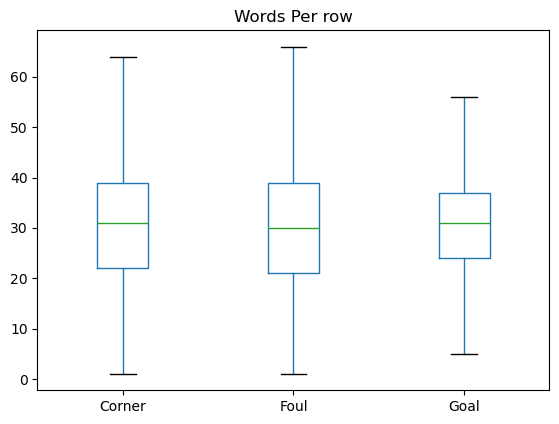

In [20]:
box_plot(df_15)

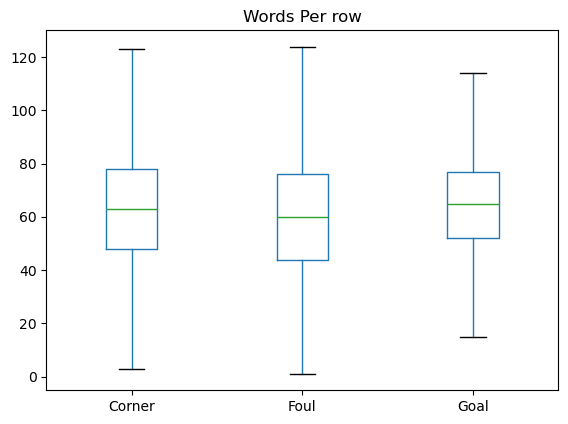

In [22]:
box_plot(df_30)

In [23]:
df_15['encoded_text'] = df_15['label'].astype('category').cat.codes
data_15 = df_15[['ASR_text','encoded_text','label']]

In [24]:
df_30['encoded_text'] = df_30['label'].astype('category').cat.codes
data_30 = df_30[['ASR_text','encoded_text','label']]

In [26]:
df_15.head(2)

,index,label,gameTime,sec,ASR_text,encoded_text
0,5,Foul,1 - 04:33,273,hanabiik real poor clearance almada nearly giv...,1
1,8,Goal,1 - 05:44,344,early warning given ref keep hands keeping toe...,2


In [27]:
df_30.head(2)

,index,label,gameTime,sec,ASR_text,encoded_text
0,5,Foul,1 - 04:33,273,box-to-box midfielder allowed play lot opposit...,1
1,8,Goal,1 - 05:44,344,jose angel di maria ball many bodies inside 18...,2


In [28]:
labels_name = data_15['label'].unique()
labels = data_15['encoded_text'].unique()

print(labels_name[0],':', labels[0])
print(labels_name[1],':', labels[1])
print(labels_name[2],':', labels[2])

Foul : 1
Goal : 2
Corner : 0


In [29]:
data_15['encoded_text'].value_counts(normalize=True).sort_index()

encoded_text
0    0.267115
1    0.639540
2    0.093344
Name: proportion, dtype: float64

In [30]:
data_30['encoded_text'].value_counts(normalize=True).sort_index()

encoded_text
0    0.266588
1    0.640462
2    0.092950
Name: proportion, dtype: float64

In [31]:
tokenizer_bert = AutoTokenizer.from_pretrained(model_ckpt_bert)

In [32]:
tokenizer_minilm = AutoTokenizer.from_pretrained(model_ckpt_minilm)

In [33]:
def tokenize_bert(batch):
    return tokenizer_bert(batch['ASR_text'],
                     truncation=True,
                     #padding=True,
                     max_length=512)

In [34]:
def tokenize_minilm(batch):
    return tokenizer_minilm(batch['ASR_text'],
                     truncation=True,
                     #padding=True,
                     max_length=512)

In [35]:
X_15 = data_15['ASR_text']
y_15 = data_15['encoded_text']
X_15.shape, y_15.shape

((16798,), (16798,))

In [36]:
X_30 = data_30['ASR_text']
y_30 = data_30['encoded_text']
X_30.shape, y_30.shape

((16880,), (16880,))

In [42]:
# Function for splitting the data into train, test and validation.
def train_test(X,y):
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(X,
                                                                        y,
                                                                        stratify=y,
                                                                        test_size = 0.4,
                                                                        shuffle=True,
                                                                        random_state = 23 )
    
    val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts,
                                                                          temp_labels,
                                                                          stratify=temp_labels,
                                                                          shuffle=True,
                                                                          test_size = 0.5,
                                                                          random_state = 23 )
    
    return train_texts, train_labels, test_texts, test_labels, val_texts, val_labels

In [43]:
train_texts_15, train_labels_15, test_texts_15, test_labels_15, val_texts_15, val_labels_15=train_test(X_15, y_15)

In [44]:
train_texts_30, train_labels_30, test_texts_30, test_labels_30, val_texts_30, val_labels_30=train_test(X_30, y_30)

In [46]:
# creating a dictionary with train, test and validation.
def dict(train_texts, train_labels, test_texts, test_labels, val_texts, val_labels):
    train = pd.concat([train_texts, train_labels], axis=1)
    validation = pd.concat([val_texts, val_labels], axis=1)
    test = pd.concat([test_texts, test_labels], axis=1)
    
    train_dataset = Dataset.from_pandas(train)
    train_dataset = train_dataset.remove_columns(['__index_level_0__'])
    
    validation_dataset = Dataset.from_pandas(validation)
    validation_dataset = validation_dataset.remove_columns(['__index_level_0__'])
    
    test_dataset = Dataset.from_pandas(test)
    test_dataset = test_dataset.remove_columns(['__index_level_0__'])
    
    split_dict = {'train': train_dataset, 'validation': validation_dataset, 'test': test_dataset}
    datasets = DatasetDict(split_dict)

    return datasets

In [47]:
datasets_15 = dict(train_texts_15, train_labels_15, test_texts_15, test_labels_15, val_texts_15, val_labels_15)

In [48]:
datasets_30 = dict(train_texts_30, train_labels_30, test_texts_30, test_labels_30, val_texts_30, val_labels_30)

In [49]:
datasets_15

DatasetDict({
    train: Dataset({
        features: ['ASR_text', 'encoded_text'],
        num_rows: 10078
    })
    validation: Dataset({
        features: ['ASR_text', 'encoded_text'],
        num_rows: 3360
    })
    test: Dataset({
        features: ['ASR_text', 'encoded_text'],
        num_rows: 3360
    })
})

In [51]:
datasets_30

DatasetDict({
    train: Dataset({
        features: ['ASR_text', 'encoded_text'],
        num_rows: 10128
    })
    validation: Dataset({
        features: ['ASR_text', 'encoded_text'],
        num_rows: 3376
    })
    test: Dataset({
        features: ['ASR_text', 'encoded_text'],
        num_rows: 3376
    })
})

<Axes: >

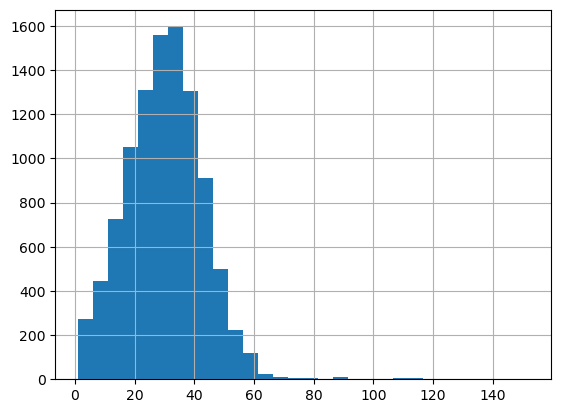

In [52]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_texts_15]

pd.Series(seq_len).hist(bins = 30)

<Axes: >

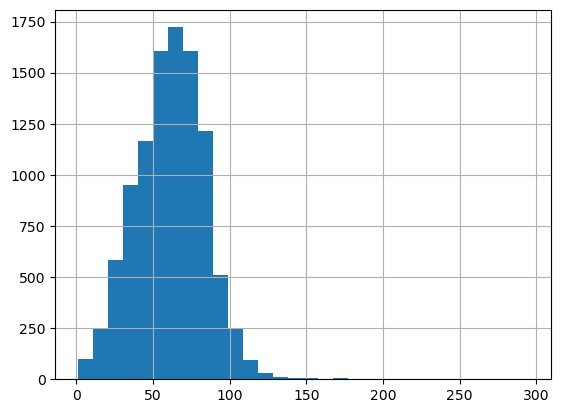

In [53]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_texts_30]

pd.Series(seq_len).hist(bins = 30)

In [58]:
def tokenize_dataset(data, token_func):
    encoded_dataset = data.map(token_func, batched=True)
    encoded_dataset = encoded_dataset.rename_column('ASR_text','text')
    encoded_dataset = encoded_dataset.rename_column('encoded_text','labels')
    return encoded_dataset

In [59]:
encoded_dataset_bert_15 = tokenize_dataset(datasets_15, tokenize_bert)
encoded_dataset_bert_15

Map: 100%|██████████| 3360/3360 [00:00<00:00, 23230.32 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10078
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3360
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3360
    })
})

In [60]:
encoded_dataset_bert_30 = tokenize_dataset(datasets_30, tokenize_bert)
encoded_dataset_bert_30

Map: 100%|██████████| 3376/3376 [00:00<00:00, 13055.97 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10128
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3376
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3376
    })
})

In [61]:
encoded_dataset_minilm_15 = tokenize_dataset(datasets_15, tokenize_minilm)
encoded_dataset_minilm_15

Map: 100%|██████████| 3360/3360 [00:00<00:00, 9425.58 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10078
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3360
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3360
    })
})

In [62]:
encoded_dataset_minilm_30 = tokenize_dataset(datasets_30, tokenize_minilm)
encoded_dataset_minilm_30

Map: 100%|██████████| 3376/3376 [00:00<00:00, 14215.42 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10128
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3376
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3376
    })
})

In [63]:
# Saving the dictionaries as pickle files.
with open('MiniLM_dataset_15.pkl', 'wb') as m: 
    pickle.dump(encoded_dataset_minilm_15, m)
    
with open('MiniLM_dataset_30.pkl', 'wb') as m: 
    pickle.dump(encoded_dataset_minilm_30, m)

In [64]:
with open('BERT_dataset_15.pkl', 'wb') as b: 
    pickle.dump(encoded_dataset_bert_15, b)

with open('BERT_dataset_30.pkl', 'wb') as b: 
    pickle.dump(encoded_dataset_bert_30, b)